# Kaggle: Kobe Bryant Shot Selection (Data Visualization)

This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Your task is to predict whether the basket went in (shot_made_flag).

We have removed 5000 of the shot_made_flags (represented as missing values in the csv file). These are the test set shots for which you must submit a prediction. You are provided a sample submission file with the correct shot_ids needed for a valid prediction.

To avoid leakage, your method should only train on events that occurred prior to the shot for which you are predicting! Since this is a playground competition with public answers, it's up to you to abide by this rule.

https://www.kaggle.com/c/kobe-bryant-shot-selection/data

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import style; style.use('ggplot')

In [2]:
data = pd.read_csv('data.csv')
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


## Plan:
In visualization notebook:
- separate train and test data
    - use all labeled data for train, all unlabeled for test
    - remember to perform all preprocessing on BOTH train and test data together
- explore train data
    - determine trends
    - make visualizations

In model notebook:
- determine relevant features
- preprocess relevant features
    - BOTH train and test together
- determine model type
    - test various models using cross validation
        - break train set into train and validation sets
    - record best model
- make predictions on test set using best model

Note) shot_made_flag is the label column

In [3]:
# separate train and test data
train = data[np.isnan(data.shot_made_flag) == False]
test = data[np.isnan(data.shot_made_flag)]

# remove shot_made_flag column from test (all nan)
test = test.drop(['shot_made_flag'], axis=1)

In [4]:
# confirm: 5000 test points, 1 less column in train
train.values.shape, test.values.shape

((25697, 25), (5000, 24))

In [5]:
# sort dataframes by date
train = train.sort_values(by='game_date')
test = test.sort_values(by='game_date')

In [6]:
list(test)

['action_type',
 'combined_shot_type',
 'game_event_id',
 'game_id',
 'lat',
 'loc_x',
 'loc_y',
 'lon',
 'minutes_remaining',
 'period',
 'playoffs',
 'season',
 'seconds_remaining',
 'shot_distance',
 'shot_type',
 'shot_zone_area',
 'shot_zone_basic',
 'shot_zone_range',
 'team_id',
 'team_name',
 'game_date',
 'matchup',
 'opponent',
 'shot_id']

## Field Goal Percentage

In [7]:
# overall fg %
np.sum(train.shot_made_flag == 1) / train.shape[0]

0.44616103047048294

In [8]:
# 2pt fg %
np.sum(train[train.shot_type == '2PT Field Goal'].shot_made_flag == 1) / np.sum(train.shot_type == '2PT Field Goal')

0.4773477939364062

In [9]:
# 3pt fg %
np.sum(train[train.shot_type == '3PT Field Goal'].shot_made_flag == 1) / np.sum(train.shot_type == '3PT Field Goal')

0.32926829268292684

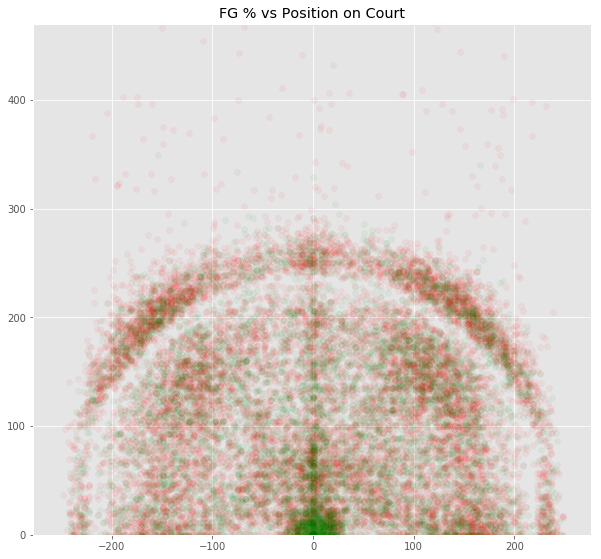

In [10]:
# setup court dimensions
plt.rcParams['figure.figsize'] = [10, 10 * (47 / 50)]

plt.scatter(train[train.shot_made_flag == 0].loc_x, 
            train[train.shot_made_flag == 0].loc_y,
            color='red', alpha=.05)

plt.scatter(train[train.shot_made_flag == 1].loc_x, 
            train[train.shot_made_flag == 1].loc_y,
            color='green', alpha=.05)

plt.ylim(0, 470)
plt.title('FG % vs Position on Court');

In [11]:
# FG % vs period
print('Period\tFG %')

for i in range(1, 5):
    temp = (np.sum(train[train.period == i].shot_made_flag == 1) / np.sum(train.period == i))
    print('%d\t%.2f' % (i, temp))

Period	FG %
1	0.47
2	0.45
3	0.45
4	0.41


Looks like Kobe actually shot better earlier in games! 

My guess: his shot selection was better given that there was more time on the clock and less pressure.

In [12]:
# get FG % vs season (graphed later with ppg)
seasons = list(train.season.unique())
avg_fg = []

for i in seasons:
    avg_fg.append(np.sum(train[train.season == i].shot_made_flag == 1) / np.sum(train.season == i))

## Points per Game

In [13]:
# PPG: make list of points for every game
dates = list(train.game_date.unique())
ppg = []

for i in dates:
    temp = train[train.game_date == i]
    pt2 = np.sum(temp[temp.shot_made_flag == 1].shot_type == '2PT Field Goal') * 2
    pt3 = np.sum(temp[temp.shot_made_flag == 1].shot_type == '3PT Field Goal') * 3
    ppg.append(pt2 + pt3)

In [14]:
# PPG: count average for season

# initialize counters, season to first season
ppg_counter = 0
games_played = 0
curr_season = train.season.iloc[0]
avg_pps = []

# go thru each unique date
for i, date in enumerate(dates):
    
    # if current season is not the same as current data point's season
    if curr_season != train[train.game_date == date].season.iloc[0] or date == dates[-1]:
        
        # add to list of average points per season
        avg_pps.append(ppg_counter / games_played)
        
        # reset counters    
        curr_season = train[train.game_date == date].season.iloc[0]
        ppg_counter = 0
        games_played = 0
    
    # add to counter if in current season
    ppg_counter += ppg[i]
    games_played += 1

## Field Goal Percentage and Points per Game

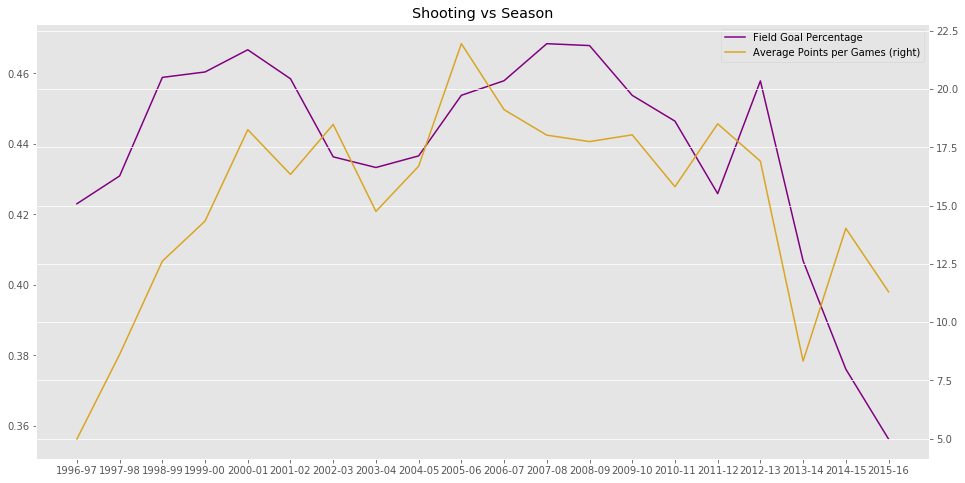

In [15]:
a = pd.DataFrame(avg_fg)
b = pd.DataFrame(avg_pps)
c = pd.concat([a, b], axis=1)

plt.rcParams['figure.figsize'] = [16, 8]

c.iloc[:, 0].plot(label='Field Goal Percentage', legend=True, color='purple')
c.iloc[:, 1].plot(label='Average Points per Games', legend=True, color='goldenrod', 
                  secondary_y=True)

plt.title('Shooting vs Season')
plt.xticks([i for i in range(20)], seasons)
plt.xlabel('Season');

Note) This data does not include free throws, so Kobe's actual points per game numbers are higher.

Looks like the number of points Kobe scored is correlated with his field goal percentage. This makes sense, and shows that he played best in the middle of his career.

## Performance vs Various Teams

In [16]:
opponents = train.opponent.unique()
opponents

array(['MIN', 'NYK', 'CHA', 'TOR', 'ATL', 'HOU', 'SAS', 'LAC', 'PHX',
       'GSW', 'UTA', 'PHI', 'BOS', 'DET', 'DEN', 'SAC', 'CHI', 'VAN',
       'POR', 'MIA', 'DAL', 'SEA', 'WAS', 'CLE', 'IND', 'NJN', 'ORL',
       'MIL', 'MEM', 'NOH', 'NOP', 'OKC', 'BKN'], dtype=object)

### Team shifts explain the 33 teams (expected 29):
Vancouver Grizzlies/Memphis Grizzlies

Brooklyn Nets/New Jersey Nets

New Orleans Hornets/New Orleans Pelicans

Seattle Supersonics/Oklahoma City Thunder

In [17]:
# dictionary with opponent, ppg, times played
opponent_dict = {k: [0, 0] for k in list(opponents)}

for i, game in enumerate(train.game_id.unique()):
    opponent_dict[train[train.game_id == game].opponent.iloc[0]][0] += ppg[i]
    opponent_dict[train[train.game_id == game].opponent.iloc[0]][1] += 1

In [18]:
# dictionary with average ppg for each opponent
ppg_dict = {k: opponent_dict[k][0] / opponent_dict[k][1] for k in list(opponents)}

# sort, then separate into 2 lists
sorted_ppg_dict = sorted(ppg_dict.items(), key=lambda x: x[1])
opponent_ls = [i[0] for i in sorted_ppg_dict]
ppg_ls = [i[1] for i in sorted_ppg_dict]

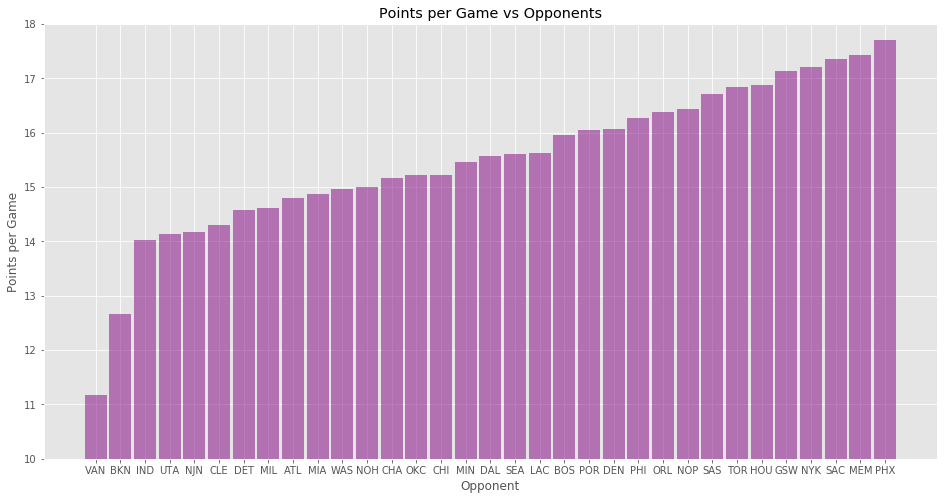

In [19]:
# bar graph of average ppg for each opponent

plt.rcParams['figure.figsize'] = [16, 8]

plt.bar([i for i in range(len(sorted_ppg_dict))], ppg_ls, 
        color='purple', width=.90, alpha=.5)
plt.xticks([i for i in range(len(sorted_ppg_dict))], opponent_ls);

plt.ylim(10, 18)
plt.title('Points per Game vs Opponents')
plt.xlabel('Opponent')
plt.ylabel('Points per Game');

In his career as a whole, Kobe scored best again Phoenix and worst against Vancouver (now Memphis). 

## Shot Type

In [20]:
# make dictionary of all shot types and the number of each
shot_types = dict(train.combined_shot_type.value_counts())

In [21]:
# sum infrequent shots
other = shot_types['Tip Shot'] + shot_types['Hook Shot'] + shot_types['Bank Shot']

# remove infrequent shots from dictionary
del shot_types['Tip Shot']
del shot_types['Hook Shot']
del shot_types['Bank Shot']

# save infrequent shots together as 'other'
shot_types['Other'] = other

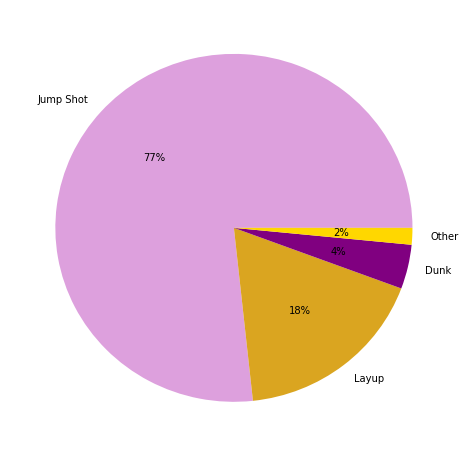

In [22]:
# make pie chart of shot types
plt.rcParams['figure.figsize'] = [8, 8]
plt.pie(x=shot_types.values(), labels=shot_types.keys(), 
        autopct='%1.0f%%', colors=['plum', 'goldenrod', 'purple', 'gold']);